## Result Visualizations with Comparison Analysis
### CHAPTER 02 - *Model Explainability Methods*

From **Applied Machine Learning Explainability Techniques** by [**Aditya Bhattacharya**](https://www.linkedin.com/in/aditya-bhattacharya-b59155b6/), published by **Packt**

### Objective

In this notebook, we will try to implement some of the concepts related to Comparison Analysis part of the result visualization based explainability methods discussed in Chapter 2 - Model Explainability Methods.

### Installing the modules

Install the following libraries in Google Colab or your local environment, if not already installed.

In [ ]:
!pip install --upgrade pandas numpy matplotlib seaborn scikit-learn

### Loading the modules

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")
np.random.seed(5)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

### About the data

Kaggle Data Source Link - [Kaggle | Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database?select=diabetes.csv)

The Pima Indian Diabetes dataset is used to predict whether or not the diagnosed patient has diabetes, which is also a Binary Classification problem, based on the various diagnostic feature values provided. The dataset used for this analysis is obtained from Kaggle. Although the dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The patient dynamics provided in this dataset is that of female patients who are at least 21 years old and of Pima Indian heritage.  The datasets used might be derived and transformed datasets from original datasets. The sources of the original datasets will be mentioned and I would strongly recommend to look at the original data for more details on the data description and for a more detailed analysis.

### Loading the data

In [2]:
data  = pd.read_csv('Datasets/diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.shape

(768, 9)

### Data Preprocessing

We will perform some preliminary pre-processing and very basic exploration as our main focus is on the comparison analysis. And since some of these methods are already covered in sufficient details in other notebook tutorials provided, I will try to jump to the important steps for the comparison analysis.

In [6]:
data[(data['BMI'] == 0) & (data['Glucose'] == 0) & (data['BloodPressure'] == 0)]
data[(data['Glucose'] == 0)]

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_ ?,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


From the above observation, it looks like the data does have alot of noise, as there are multiple cases where some of the key features are 0. But, following human intuition, since blood glucose level is one of the key features to observe diabetes, I would consider dropping all records where Glucose value is 0.

In [4]:
cleaned_data = data[(data['Glucose'] != 0)]
cleaned_data.shape

(763, 9)

In [5]:
feature_engg_data = cleaned_data.copy()
outlier_data = cleaned_data.copy()
factor = 3
# Include this only for columns with suspected outliers
# Using a factor of 3, following Nelson's rule 1 to remove outliers - https://en.wikipedia.org/wiki/Nelson_rules
# Only for non-categorical fields
columns_to_include = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction']
for column in columns_to_include:
    upper_lim = feature_engg_data[column].mean () + feature_engg_data[column].std () * factor
    lower_lim = feature_engg_data[column].mean () - feature_engg_data[column].std () * factor
    feature_engg_data = feature_engg_data[(feature_engg_data[column] < upper_lim) & (feature_engg_data[column] > lower_lim)]
    
outlier_data = pd.concat([outlier_data, feature_engg_data]).drop_duplicates(keep=False)

print(feature_engg_data.shape)
print(outlier_data.shape)

(688, 9)
(75, 9)


In the following section in-order to build the model, we will need to normalize the data and split the data into train, validation and test dataset. The outlier data that we have, we will keep it separate, just in case to see how does our model performs on the outlier dataset.

In [6]:
def normalize_data(df):
    val = df.values 
    min_max_normalizer = preprocessing.MinMaxScaler()
    norm_val = min_max_normalizer.fit_transform(val)
    df2 = pd.DataFrame(norm_val, columns=df.columns)
    
    return df2

norm_feature_engg_data = normalize_data(feature_engg_data)
norm_outlier_data = normalize_data(outlier_data)

In the previous steps we have done some fundamental steps to understand and prepare the data so that it can be used for further modeling. Let's split the data and then we will try to apply the comparison analysis for result visualization based explainability.

### Splitting the data

In [7]:
input_data = norm_feature_engg_data.drop(['Outcome'],axis='columns')
targets =norm_feature_engg_data.filter(['Outcome'],axis='columns')

x, x_test, y, y_test = train_test_split(input_data,targets,test_size=0.1,train_size=0.9, random_state=5)
x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size = 0.22,train_size =0.78, random_state=5)

### t-SNE based visualization

Now, to compare the classes and the formation of the clusters, we will perform t-SNE based visualization and observe the goodness of the clusters. If the clusters are not compact and well separated, it is highly possible that any classification algorithm will not work effectively because of the data formation.t-Distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction method, which is often used with clustering. To find out more on this method, please refer this link: https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1.

In [8]:
def visualize_clusters(x, labels, hue = "hls"):
    '''
    Visualization of clusters using t-SNE plots
    '''
    tsne_transformed = TSNE(n_components=2, random_state = 0).fit_transform(x)

    df_tsne_subset = pd.DataFrame()
    df_tsne_subset['tsne-one'] = tsne_transformed[:,0]
    df_tsne_subset['tsne-two'] = tsne_transformed[:,1]
    df_tsne_subset['y'] = labels

    plt.figure(figsize=(6,4))
    sns.scatterplot(
        x="tsne-one", y="tsne-two",
        hue="y",
        palette=sns.color_palette(hue,df_tsne_subset['y'].nunique()),
        data=df_tsne_subset,
        legend="full",
        alpha=1.0
    )
    plt.show()

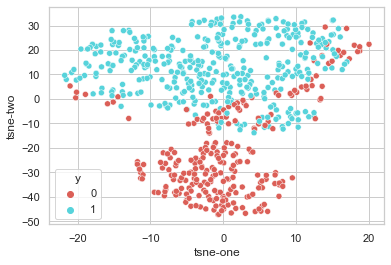

In [13]:
# K-means
model = KMeans(n_clusters=2, init='k-means++', random_state=0)
model.fit(x)
km_labels = model.predict(x)
visualize_clusters(x, km_labels)

As we can see that overall, the clusters does have a compact shape and can be separated. If the clusters were not properly formed and if the t_SNE transfored data points we sparse and spread out, we could have hypothesized that any classification algorithm might also fail. But in this, apart from few data points, most of the points are part pf th two distinguishable clusters which are formed. More detailed comparison analysis can be done to identify key information about those points which are not part of the correct clusters. But we will not cover those in this notebook to keep things simple!

### Final Thoughts

The methods explored in this notebook, are all model agnostic approaches for explaining black-box models. These methods are very simple to execute and quite human friendly depending on the Surrogate Explainer methods used. Also, the result visualizations doesn't need any complicated level of understanding, so very effective for business stakeholders. But the major drawback is that these methods doesn't include the information learnt from the actual model. The actual model might learn important information and might unravel certain critical features which might not be picked up the Surrogate models. Overall, this is one of the most common methods for explaining black-box models, mainly because of its simplicity. Try out this method for regression based problems.

### Reference

1. UCI Machine Learning Repository -https://archive.ics.uci.edu/ml/datasets/adult
3. Some of the utility functions and code are taken from the GitHub Repository of the author - Aditya Bhattacharya https://github.com/adib0073